In [1]:
import collections
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from lightgbm import LGBMRegressor, LGBMClassifier
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
import gc
import json
from halo import Halo
from numerapi import NumerAPI
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

In [2]:
from utils import (
    save_model,
    load_model,
    neutralize,
    get_biggest_change_features,
    validation_metrics,
    get_time_series_cross_val_splits,
    save_model_config,
    load_model_config,
    ERA_COL,
    DATA_TYPE_COL,
    TARGET_COL,
    EXAMPLE_PREDS_COL
)
napi = NumerAPI()

## All training and model configs

In [3]:
model_configs = {
    "LGBM_cfg1": {
        "n_estimators": 2000,
        "learning_rate": 0.01,
        "max_depth": 5,
        "num_leaves": 2 ** 5,
        "colsample_bytree": 0.1
    },
    "LGBM_cfg2": {
        "n_estimators": 3000,
        "learning_rate": 0.005,
        "max_depth": 5,
        "num_leaves": 2 ** 5,
        "colsample_bytree": 0.1
    },
    "RF_cfg1": {
        "n_estimators": 1000,
        "criterion": "squared_error",
        "max_depth": 5,
        "min_samples_leaf": 5
    },
    "RF_cfg2": {
        "n_estimators": 2000,
        "criterion": "squared_error",
        "max_depth": 3,
        "min_samples_leaf": 5
    },
    "XGB_cfg1": {
        "n_estimators": 2000,
        "learning_rate": 0.01,
        "max_depth": 5,
        "colsample_bytree": 0.1
    },
    "RF_cfg2": {
        "n_estimators": 3000,
        "learning_rate": 0.005,
        "max_depth": 5,
        "colsample_bytree": 0.1
    },
}

In [4]:
training_configs = {
    "FEATURE_SET": "medium",
    "MODEL_CONFIG": "LGBM_cfg1",
}

In [5]:
current_round = napi.get_current_round(tournament=8)  # tournament 8 is the primary Numerai Tournament
# napi.download_dataset("numerai_tournament_data.parquet", f"data/tournament_data_{current_round}.parquet")

In [6]:
spinner = Halo(text='', spinner='dots')

## Feature set information

In [7]:
with open("data/features.json", "r") as f:
    feature_metadata = json.load(f)

In [8]:
feature_set = training_configs["FEATURE_SET"]
features = feature_metadata["feature_sets"][feature_set]

In [9]:
feature_metadata["feature_sets"].keys()

dict_keys(['legacy', 'small', 'medium'])

In [10]:
len(features)

420

In [11]:
# read in just those features along with era and target columns
read_columns = features + [ERA_COL, DATA_TYPE_COL, TARGET_COL]
training_data = pd.read_parquet('data/numerai_training_data.parquet', columns=read_columns)

In [12]:
training_data.head()

,feature_dichasial_hammier_spawner,feature_rheumy_epistemic_prancer,feature_pert_performative_hormuz,feature_hillier_unpitied_theobromine,feature_perigean_bewitching_thruster,feature_renegade_undomestic_milord,feature_koranic_rude_corf,feature_demisable_expiring_millepede,feature_unscheduled_malignant_shingling,feature_clawed_unwept_adaptability,...,feature_hemispherical_unabsolved_aeolipile,feature_glyptic_unrubbed_holloway,feature_rimmed_conditional_archipelago,feature_bleeding_arabesque_pneuma,feature_dipped_sent_giuseppe,feature_undivorced_unsatisfying_praetorium,feature_reclinate_cruciform_lilo,era,data_type,target_nomi_20
id,,,,,,,,,,,,,,,,,,,,,
n003bba8a98662e4,1.0,0.50,1.00,1.00,0.00,0.00,1.00,1.00,0.75,0.00,...,1.00,0.75,0.50,0.75,1.00,0.50,0.25,0001,train,0.25
n003bee128c2fcfc,0.5,1.00,0.25,0.75,0.00,0.75,0.50,0.75,0.50,0.50,...,0.00,0.25,0.25,0.25,0.25,0.75,0.75,0001,train,0.75
n0048ac83aff7194,0.5,0.25,0.75,0.00,0.75,0.00,0.75,0.75,1.00,0.50,...,0.00,0.50,1.00,0.75,0.75,1.00,0.75,0001,train,0.50
n00691bec80d3e02,1.0,0.50,0.50,0.75,0.00,1.00,0.25,1.00,0.25,0.75,...,0.50,0.50,0.00,0.50,0.50,0.00,0.25,0001,train,0.75
n00b8720a2fdc4f2,1.0,0.75,1.00,1.00,0.00,0.00,1.00,0.50,0.75,0.00,...,0.25,1.00,0.75,1.00,1.00,0.50,0.50,0001,train,0.75


## Correlation check: Avoid substitution effects
If correlation between a pair of features is too high, then remove one of them. Use data at era0001 to check

In [13]:
feature_corrs = training_data[training_data.era=='0574'][features].corr()

In [14]:
tdf = feature_corrs.stack()
tdf = tdf[tdf.index.get_level_values(0) < tdf.index.get_level_values(1)]
tdf.sort_values()

feature_calycled_living_birmingham            feature_dentilingual_removed_osmometer     -0.967035
feature_criticisable_authentical_deprecation  feature_invalid_extortionary_titillation   -0.959433
feature_demure_groutiest_housedog             feature_stelar_balmiest_pellitory          -0.949275
feature_hydrologic_cymric_nyctophobia         feature_hypermetropic_unsighted_forsyth    -0.949220
feature_exacerbating_presentationism_apagoge  feature_paraffinoid_irreplevisable_ombu    -0.941962
                                                                                            ...   
feature_fake_trident_agitator                 feature_wieldable_defiled_aperitive         0.987590
feature_gullable_sanguine_incongruity         feature_reported_slimy_rhapsody             0.988113
feature_caressive_cognate_cubature            feature_crablike_panniered_gloating         0.989254
feature_together_suppositive_aster            feature_transmontane_clerkly_value          0.989877
feature_lo

In [15]:
highly_correlated_cols = [col1 for col1, _ in tdf[(tdf>0.8) | (tdf<-0.8)].index.values]
highly_correlated_cols = list(set(highly_correlated_cols))
len(highly_correlated_cols)

245

In [16]:
# Remove 245 features that is highly correlated
transformed_data = training_data.loc[:, ~training_data.columns.isin(highly_correlated_cols)]

In [17]:
transformed_data.head()

,feature_pert_performative_hormuz,feature_renegade_undomestic_milord,feature_koranic_rude_corf,feature_unscheduled_malignant_shingling,feature_rubblier_chlorotic_stogy,feature_untumbled_histologic_inion,feature_unluckiest_mulley_benzyl,feature_escutcheoned_timocratic_kotwal,feature_vedic_mitral_swiz,feature_gone_honduran_worshipper,...,feature_malacological_differential_defeated,feature_unextinct_smectic_isa,feature_springlike_crackjaw_bheesty,feature_unweary_congolese_captain,feature_uncertified_myrmecological_nagger,feature_hemispherical_unabsolved_aeolipile,feature_reclinate_cruciform_lilo,era,data_type,target_nomi_20
id,,,,,,,,,,,,,,,,,,,,,
n003bba8a98662e4,1.00,0.00,1.00,0.75,0.50,1.00,0.00,1.0,1.00,0.50,...,0.50,0.00,0.50,1.00,0.75,1.00,0.25,0001,train,0.25
n003bee128c2fcfc,0.25,0.75,0.50,0.50,0.50,0.25,0.75,0.0,0.25,0.25,...,0.00,0.50,0.50,0.00,0.25,0.00,0.75,0001,train,0.75
n0048ac83aff7194,0.75,0.00,0.75,1.00,0.00,0.00,0.50,0.5,0.75,0.00,...,0.50,0.25,0.25,0.50,0.50,0.00,0.75,0001,train,0.50
n00691bec80d3e02,0.50,1.00,0.25,0.25,0.25,1.00,0.25,0.5,0.50,0.25,...,0.75,0.00,0.00,0.50,0.50,0.50,0.25,0001,train,0.75
n00b8720a2fdc4f2,1.00,0.00,1.00,0.75,0.25,0.75,0.75,0.0,0.25,0.25,...,0.75,0.25,0.25,0.75,0.00,0.25,0.50,0001,train,0.75


In [18]:
uncorrelated_feats = [feat for feat in features if feat not in set(highly_correlated_cols)]
len(uncorrelated_feats)

175

## Stationarity check

Do the stationarity check on correlation between features across eras. If the correlation of a feature pairs shows nonstationarity, log transform it

In [19]:
feature_corrs = transformed_data[transformed_data.era=='0002'][uncorrelated_feats + [TARGET_COL]].corr()

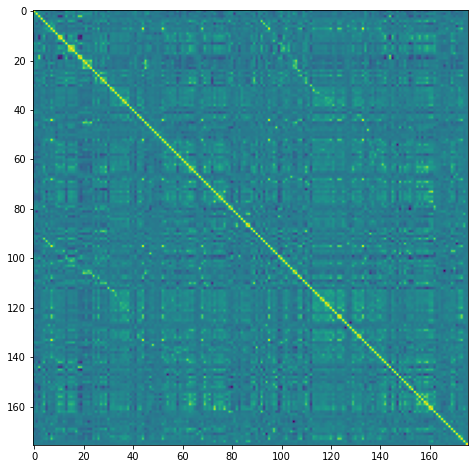

In [20]:
plt.figure(figsize = (8,8))
plt.imshow(feature_corrs)
plt.show()

In [21]:
data_by_era = []
for era in range(1, 575):
    data_by_era.append(transformed_data.groupby("era").get_group("{0:04d}".format(era)))

In [22]:
corrs_by_era = []
for i in range(len(data_by_era)):
    corrs_by_era.append(data_by_era[i][uncorrelated_feats + [TARGET_COL]].corr())

In [23]:
len(corrs_by_era)

574

In [24]:
all_cols = corrs_by_era[0].columns.values

In [25]:
len(all_cols)

176

In [26]:
# non_stationary_pairs = []
stationary_cols = collections.defaultdict(int)
# pairs_cols = features + [TARGET_COL]
for feat_i in range(len(all_cols)):
    for feat_j in range(feat_i + 1, len(all_cols)):
        # print(all_cols[feat_i], all_cols[feat_j])
        series = [era_corrs.iloc[feat_i, feat_j] for era_corrs in corrs_by_era]
        result = adfuller(series)
        p_value = result[1]
        if p_value > 0.05:
            stationary_cols[all_cols[feat_i]] += 1
            stationary_cols[all_cols[feat_j]] += 1
            # non_stationary_pairs.append((all_cols[feat_i], all_cols[feat_j]))

In [27]:
# Look at how many times a feature involves in a nonstationary pair in terms of correlation
sorted([(stationary_cols[k], k) for k in stationary_cols])

[(1, 'feature_reclinate_cruciform_lilo'),
 (1, 'feature_unsparred_scarabaeid_anthologist'),
 (2, 'feature_nucleophilic_uremic_endogen'),
 (2, 'feature_sallowish_cognisant_romaunt'),
 (2, 'feature_scenic_cormophytic_bilirubin'),
 (3, 'feature_sudsy_polymeric_posteriority'),
 (6, 'feature_merovingian_tenebrism_hartshorn'),
 (7, 'feature_unknown_reusable_cabbage'),
 (7, 'feature_vestmental_hoofed_transpose'),
 (8, 'feature_enlightening_mirthful_laurencin'),
 (8, 'feature_recidivism_petitory_methyltestosterone'),
 (10, 'feature_fierier_goofier_follicle'),
 (10, 'feature_zarathustrian_albigensian_itch'),
 (11, 'feature_trim_axial_suffocation'),
 (13, 'feature_gossamer_placable_wycliffite'),
 (13, 'feature_uncomplimentary_malignant_scoff'),
 (14, 'feature_uninclosed_handcrafted_springing'),
 (16, 'feature_untrimmed_monaxial_accompanist'),
 (16, 'feature_voltairean_dyslogistic_epagoge'),
 (17, 'feature_midget_noncognizable_plenary'),
 (20, 'feature_invalid_chromatographic_cornishman'),
 (21, 

In [28]:
len(sorted([(stationary_cols[k], k) for k in stationary_cols]))

174

In [29]:
len(all_cols)

176

In [30]:
# Most features involve in multiple nonstationary pairs -> log transform the features
for col in stationary_cols:
    transformed_data[col] = np.log(transformed_data[col] + 1)


/var/folders/cx/74c09p4917dbnxyclq4tvqkc0000gn/T/ipykernel_37779/1996065810.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transformed_data[col] = np.log(transformed_data[col] + 1)


In [31]:
transformed_data.head()

,feature_pert_performative_hormuz,feature_renegade_undomestic_milord,feature_koranic_rude_corf,feature_unscheduled_malignant_shingling,feature_rubblier_chlorotic_stogy,feature_untumbled_histologic_inion,feature_unluckiest_mulley_benzyl,feature_escutcheoned_timocratic_kotwal,feature_vedic_mitral_swiz,feature_gone_honduran_worshipper,...,feature_malacological_differential_defeated,feature_unextinct_smectic_isa,feature_springlike_crackjaw_bheesty,feature_unweary_congolese_captain,feature_uncertified_myrmecological_nagger,feature_hemispherical_unabsolved_aeolipile,feature_reclinate_cruciform_lilo,era,data_type,target_nomi_20
id,,,,,,,,,,,,,,,,,,,,,
n003bba8a98662e4,0.693147,0.000000,0.693147,0.559616,0.405465,0.693147,0.000000,0.693147,0.693147,0.405465,...,0.405465,0.000000,0.405465,0.693147,0.559616,0.693147,0.223144,0001,train,0.25
n003bee128c2fcfc,0.223144,0.559616,0.405465,0.405465,0.405465,0.223144,0.559616,0.000000,0.223144,0.223144,...,0.000000,0.405465,0.405465,0.000000,0.223144,0.000000,0.559616,0001,train,0.75
n0048ac83aff7194,0.559616,0.000000,0.559616,0.693147,0.000000,0.000000,0.405465,0.405465,0.559616,0.000000,...,0.405465,0.223144,0.223144,0.405465,0.405465,0.000000,0.559616,0001,train,0.50
n00691bec80d3e02,0.405465,0.693147,0.223144,0.223144,0.223144,0.693147,0.223144,0.405465,0.405465,0.223144,...,0.559616,0.000000,0.000000,0.405465,0.405465,0.405465,0.223144,0001,train,0.75
n00b8720a2fdc4f2,0.693147,0.000000,0.693147,0.559616,0.223144,0.559616,0.559616,0.000000,0.223144,0.223144,...,0.559616,0.223144,0.223144,0.559616,0.000000,0.223144,0.405465,0001,train,0.75


In [32]:
transformed_data.shape

(2412105, 178)

## Dimensionality Reduction

In [ ]:
pca = PCA(n_components = 0.95)      # to explain 95% of variance
numerical_data = transformed_data.loc[:, ~transformed_data.columns.isin(["data_type", "target_nomi_20"])]
pca.fit(numerical_data)
reduced_data = pca.transform(numerical_data)

## Feature Selection

In [33]:
model_clf_configs = {
    "LGBM_cfg1": {
        "n_estimators": 2000,
        "learning_rate": 0.01,
        "max_depth": 5,
        "num_leaves": 2 ** 5,
        "colsample_bytree": 0.1
    },
    "LGBM_cfg2": {
        "n_estimators": 3000,
        "learning_rate": 0.005,
        "max_depth": 5,
        "num_leaves": 2 ** 5,
        "colsample_bytree": 0.1
    },
    "RF_bl": {
        "max_features": 1,
    },
}

### MDA analysis with Baseline Random Forest

In [34]:
model_clf_config = "RF_bl"

In [49]:
def MDA(X, y, k):
    cv = StratifiedKFold(n_splits=k, random_state=1, shuffle=True)

    aucs, accs = [], []
    clf = RandomForestClassifier(**model_clf_configs["RF_bl"])
    result = pd.DataFrame(columns=X.columns)
    accs = pd.Series()
        
    for (train, test), i in zip(cv.split(X, y), range(k)):
        clf.fit(X.iloc[train], y.iloc[train])
        y_pred = clf.predict(X.iloc[test])

        acc = accuracy_score(y.iloc[test], y_pred)
        accs.loc[i] = acc

        X_test = X.iloc[test].copy(deep=True)
        for j in X.columns:
            np.random.shuffle(X_test[j].values) # permutation of a single column 
            
            pred = clf.predict(X_test) 
            result.loc[i, j] = accuracy_score(y.iloc[test], pred)

    return accs, result

In [46]:
X = transformed_data.filter(like='feature_', axis='columns')
y = transformed_data[TARGET_COL].values.reshape(-1, 1)
# ohe = OneHotEncoder()
le = LabelEncoder()
# y = ohe.fit_transform(y).toarray()
y = pd.Series(le.fit_transform(y))

/Users/luckywang/Documents/Document/Course Material/Fall 2021/ORIE 5256/numerai/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [47]:
print(X.shape)
print(y.shape)

(2412105, 175)
(2412105,)


In [50]:
accs, result = MDA(X, y, 2)

/var/folders/cx/74c09p4917dbnxyclq4tvqkc0000gn/T/ipykernel_37779/3861423019.py:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  accs = pd.Series()


In [ ]:
result

In [ ]:
imp = (-result).add(accs, axis=0)
imp = imp/(1.-result)
imp = pd.concat({'mean':imp.mean(),'std':imp.std() * imp.shape[0] ** -.5}, axis=1)

In [ ]:
imp

## Train Regression models (LGBM, RF, XGBOOST)

In [ ]:
model_config = "RF_cfg1"

In [12]:
model_name = "model_{}_{}".format(feature_set, model_config)
print(f"Checking for existing model '{model_name}'")
model = load_model(model_name)
if not model:
    print(f"model not found, creating new one")
    params = model_configs[model_config]

    if model_config.startswith("LGBM"):
        model = LGBMRegressor(**params)
    elif model_config.startswith("RF"):
        model = RandomForestRegressor(**params)
    else:
        model = XGBRegressor(**params)

    # train on all of train and save the model so we don't have to train next time
    spinner.start('Training model')
    model.fit(training_data.filter(like='feature_', axis='columns'),
              training_data[TARGET_COL])
    print(f"saving new model: {model_name}")
    save_model(model, model_name)
    spinner.succeed()


Checking for existing model 'model_medium_LGBM_cfg1'


In [13]:
gc.collect()

94

In [29]:
print('Reading minimal features of validation and tournament data...')
validation_data = pd.read_parquet('data/numerai_validation_data.parquet',
                                  columns=read_columns)

Reading minimal features of validation and tournament data...


In [30]:
tournament_data = pd.read_parquet(f'data/tournament_data_{current_round}.parquet',
                                  columns=read_columns)
nans_per_col = tournament_data[tournament_data["data_type"] == "live"].isna().sum()

In [16]:
# check for nans and fill nans
if nans_per_col.any():
    total_rows = len(tournament_data[tournament_data["data_type"] == "live"])
    print(f"Number of nans per column this week: {nans_per_col[nans_per_col > 0]}")
    print(f"out of {total_rows} total rows")
    print(f"filling nans with 0.5")
    tournament_data.loc[:, features].fillna(0.5, inplace=True)
else:
    print("No nans in the features this week!")


Number of nans per column this week: target_nomi_20    5384
dtype: int64
out of 5384 total rows
filling nans with 0.5


In [17]:
spinner.start('Predicting on validation and tournament data')
# double check the feature that the model expects vs what is available to prevent our
# pipeline from failing if Numerai adds more data and we don't have time to retrain!
model_expected_features = model.booster_.feature_name()
if set(model_expected_features) != set(features):
    print(f"New features are available! Might want to retrain model {model_name}.")
validation_data.loc[:, f"preds_{model_name}"] = model.predict(
    validation_data.loc[:, model_expected_features])
tournament_data.loc[:, f"preds_{model_name}"] = model.predict(
    tournament_data.loc[:, model_expected_features])
spinner.succeed()

gc.collect()

✔ Predicting on validation and tournament data


23

In [18]:
all_feature_corrs = training_data.groupby(ERA_COL).apply(
    lambda era: era[features].corrwith(era[TARGET_COL])
)
riskiest_features = get_biggest_change_features(all_feature_corrs, 50)

In [19]:
spinner.start('Neutralizing to risky features')

# neutralize our predictions to the riskiest features
validation_data[f"preds_{model_name}_neutral_riskiest_50"] = neutralize(
    df=validation_data,
    columns=[f"preds_{model_name}"],
    neutralizers=riskiest_features,
    proportion=1.0,
    normalize=True,
    era_col=ERA_COL
)

tournament_data[f"preds_{model_name}_neutral_riskiest_50"] = neutralize(
    df=tournament_data,
    columns=[f"preds_{model_name}"],
    neutralizers=riskiest_features,
    proportion=1.0,
    normalize=True,
    era_col=ERA_COL
)
spinner.succeed()


✔ Neutralizing to risky features


In [28]:
current_round

292

In [22]:
model_to_submit = f"preds_{model_name}_neutral_riskiest_50"

# rename best model to "prediction" and rank from 0 to 1 to meet upload requirements
validation_data["prediction"] = validation_data[model_to_submit].rank(pct=True)
tournament_data["prediction"] = tournament_data[model_to_submit].rank(pct=True)
validation_data["prediction"].to_csv(f"pred/validation_predictions_{model_name}_{current_round}.csv")
tournament_data["prediction"].to_csv(f"pred/tournament_predictions_{model_name}_{current_round}.csv")


In [82]:
model_to_submit = f"preds_{model_name}"

validation_data["prediction_w_risk"] = validation_data[model_to_submit].rank(pct=True)
tournament_data["prediction_w_risk"] = tournament_data[model_to_submit].rank(pct=True)
validation_data["prediction_w_risk"].to_csv(f"pred/validation_predictions_{model_name}_{current_round}.csv")
tournament_data["prediction_w_risk"].to_csv(f"pred/tournament_predictions_{model_name}_{current_round}.csv")

In [ ]:
model_to_submit = f"preds_{model_name}_neutral_riskiest_50"

# rename best model to "prediction" and rank from 0 to 1 to meet upload requirements
validation_data["prediction"] = validation_data[model_to_submit].rank(pct=True)
tournament_data["prediction"] = tournament_data[model_to_submit].rank(pct=True)
validation_data["prediction"].to_csv(f"pred/validation_predictions_{model_name}_{current_round}.csv")
tournament_data["prediction"].to_csv(f"pred/tournament_predictions_{model_name}_{current_round}.csv")

In [27]:
validation_data.head()

,feature_dichasial_hammier_spawner,feature_rheumy_epistemic_prancer,feature_pert_performative_hormuz,feature_hillier_unpitied_theobromine,feature_perigean_bewitching_thruster,feature_renegade_undomestic_milord,feature_koranic_rude_corf,feature_demisable_expiring_millepede,feature_unscheduled_malignant_shingling,feature_clawed_unwept_adaptability,...,feature_dipped_sent_giuseppe,feature_undivorced_unsatisfying_praetorium,feature_reclinate_cruciform_lilo,era,data_type,target_nomi_20,preds_model_medium_LGBM_cfg1,preds_model_medium_LGBM_cfg1_neutral_riskiest_50,prediction,example_preds
id,,,,,,,,,,,,,,,,,,,,,
n000777698096000,0.50,0.50,0.25,0.25,0.00,0.00,0.00,0.75,1.00,0.25,...,1.00,0.50,1.0,0857,validation,0.25,0.475515,-1.015812,0.141486,NaN
n0009793a3b91c27,0.75,0.25,0.50,0.75,1.00,0.00,0.25,0.25,1.00,0.25,...,0.50,0.25,0.5,0857,validation,0.50,0.509630,0.296737,0.623966,NaN
n00099ccd6698ab0,0.25,0.75,0.00,0.75,1.00,0.75,1.00,1.00,0.75,1.00,...,1.00,0.25,1.0,0857,validation,0.00,0.517587,0.562613,0.725224,NaN
n0019e36bbb8702b,0.50,1.00,0.25,0.75,0.75,0.50,0.00,0.75,0.00,0.25,...,0.75,0.25,1.0,0857,validation,0.50,0.507401,0.124685,0.552808,NaN
n0028cb874439df8,0.00,0.75,0.00,0.25,1.00,0.50,0.00,0.00,0.00,0.50,...,1.00,1.00,1.0,0857,validation,0.50,0.486497,-0.633783,0.247748,NaN


In [124]:
validation_data[["prediction_w_risk", "prediction", "preds_model_medium_LGBM_cfg1", "preds_model_medium_LGBM_cfg1_neutral_riskiest_50", "target_nomi_20"]].head()

,prediction_w_risk,prediction,preds_model_medium_LGBM_cfg1,preds_model_medium_LGBM_cfg1_neutral_riskiest_50,target_nomi_20
id,,,,,
n000777698096000,0.026383,0.141486,0.475515,-1.015812,0.25
n0009793a3b91c27,0.766374,0.623966,0.509630,0.296737,0.50
n00099ccd6698ab0,0.906050,0.725224,0.517587,0.562613,0.00
n0019e36bbb8702b,0.711680,0.552808,0.507401,0.124685,0.50
n0028cb874439df8,0.129547,0.247748,0.486497,-0.633783,0.50


In [33]:
validation_data["target_nomi_20"].value_counts()

0.50    269876
0.25    107918
0.75    107918
1.00     26980
0.00     26966
Name: target_nomi_20, dtype: int64

## Regression to Classification

In [39]:
def val2class(x):
    if 0 <= x < 0.125:
        return 0
    elif 0.125 <= x < 0.375:
        return 1
    elif 0.375 <= x < 0.625:
        return 2
    elif 0.625 <= x < 0.875:
        return 3
    else:
        return 4


In [86]:
# model as multiclass classification
y_class = validation_data["target_nomi_20"].apply(val2class).values.reshape(-1, 1)
y_pred = validation_data["prediction_w_risk"].apply(val2class).values.reshape(-1, 1)

In [87]:
print(y_class.shape)
print(y_pred.shape)

(539658, 1)
(539658, 1)


In [88]:
ohe = OneHotEncoder()
y_class = ohe.fit_transform(y_class).toarray()
y_pred = ohe.transform(y_pred).toarray()

In [89]:
print(y_class.shape)
print(y_pred.shape)

(539658, 5)
(539658, 5)


In [90]:
roc_auc_score(y_class, y_pred, multi_class="ovr")

0.5125012650278737

## Train classifiers

In [20]:
model_clf_configs = {
    "LGBM_cfg1": {
        "n_estimators": 2000,
        "learning_rate": 0.01,
        "max_depth": 5,
        "num_leaves": 2 ** 5,
        "colsample_bytree": 0.1
    },
    "LGBM_cfg2": {
        "n_estimators": 3000,
        "learning_rate": 0.005,
        "max_depth": 5,
        "num_leaves": 2 ** 5,
        "colsample_bytree": 0.1
    },
}

In [21]:
model_clf_config = "LGBM_cfg1"

In [25]:
model_name = "model_clf_{}_{}".format(feature_set, model_clf_config)
print(f"Checking for existing model '{model_name}'")
model = load_model(model_name)
if not model:
    print(f"model not found, creating new one")
    params = model_clf_configs[model_clf_config]

    if model_clf_config.startswith("LGBM"):
        model = LGBMClassifier(**params)
    else:
        print("Not support")
    # elif model_config.startswith("RF"):
    #     model = RandomForestRegressor(**params)
    # else:
    #     model = XGBRegressor(**params)

    # train on all of train and save the model so we don't have to train next time
    spinner.start('Training model')
    y = training_data[TARGET_COL].values.reshape(-1, 1)
    ohe = OneHotEncoder()
    y = ohe.fit_transform(y).toarray()
    
    model = OneVsRestClassifier(model).fit(training_data.filter(like='feature_', axis='columns'), y)#.predict(X)
    # model.fit(training_data.filter(like='feature_', axis='columns'), y)
    print(f"saving new model: {model_name}")
    save_model(model, model_name)
    spinner.succeed()


Checking for existing model 'model_clf_small_LGBM_cfg1'
model not found, creating new one
⠋
✔ Training model


In [35]:
y = validation_data[TARGET_COL].values.reshape(-1, 1)
ohe = OneHotEncoder()
y = ohe.fit_transform(y).toarray()

In [33]:
# model_expected_features = model.booster_.feature_name()
y_pred = model.predict(validation_data.filter(like='feature_', axis='columns'))

In [36]:
roc_auc_score(y, y_pred, multi_class="ovr")

0.51803957892829

In [ ]:
spinner.start('Reading example validation predictions')
# validation_preds = pd.read_parquet(f"pred/validation_predictions_{model_name}_{current_round}.csv")
validation_preds = pd.read_csv(f"pred/validation_predictions_{model_name}_{current_round}.csv")
validation_data[EXAMPLE_PREDS_COL] = validation_preds["prediction"]
spinner.succeed()

# get some stats about each of our models to compare...
# fast_mode=True so that we skip some of the stats that are slower to calculate
# validation_stats = validation_metrics(validation_data, [model_to_submit], example_col=EXAMPLE_PREDS_COL, fast_mode=True)
# print(validation_stats[["mean", "sharpe"]].to_markdown())
# print(validation_stats)

## Advanced Model

In [41]:
advanced_model_configs = {
    "LGBM_cfg1": {
        "n_estimators": 2000,
        "learning_rate": 0.01,
        "max_depth": 5,
        "num_leaves": 2 ** 5,
        "colsample_bytree": 0.1
    },
    "LGBM_cfg2": {
        "n_estimators": 3000,
        "learning_rate": 0.005,
        "max_depth": 5,
        "num_leaves": 2 ** 5,
        "colsample_bytree": 0.1
    },
    "RF_cfg1": {
        "n_estimators": 1000,
        "criterion": "squared_error",
        "max_depth": 5,
        "min_samples_leaf": 5
    },
    "RF_cfg2": {
        "n_estimators": 2000,
        "criterion": "squared_error",
        "max_depth": 3,
        "min_samples_leaf": 5
    },

}

In [42]:
advanced_training_configs = {
    "FEATURE_SET": "medium",
    "MODEL_CONFIG": "LGBM_cfg1",
    "downsample_cross_val": 20,
    "downsample_full_train": 1,
    "model_selection_loop": True,
    "model_config_name": "advanced_example_model",
}

In [ ]:
model_config_name = "LGBM_cfg1"
model_params = advanced_model_configs[model_config_name]

print("Entering model selection loop.  This may take awhile.")
if advanced_training_configs["model_selection_loop"]:
    model_config = {}
    print('downloading training_data')

    # keep track of some prediction columns
    ensemble_cols = set()
    pred_cols = set()

    # pick some targets to use
    possible_targets = [c for c in training_data.columns if c.startswith("target_")]
    # randomly pick a handful of targets
    # this can be vastly improved
    targets = ["target_nomi_20"]

    # all the possible features to train on
    feature_cols = [c for c in training_data if c.startswith("feature_")]

    """ do cross val to get out of sample training preds"""
    cv = 3
    train_test_zip = get_time_series_cross_val_splits(training_data, cv=cv, embargo=12)
    # get out of sample training preds via embargoed time series cross validation
    # optionally downsample training data to speed up this section.
    print("entering time series cross validation loop")
    for split, train_test_split in enumerate(train_test_zip):
        gc.collect()
        print(f"doing split {split+1} out of {cv}")
        train_split, test_split = train_test_split
        train_split_index = training_data[ERA_COL].isin(train_split)
        test_split_index = training_data[ERA_COL].isin(test_split)
        downsampled_train_split_index = train_split_index[train_split_index].index[::advanced_training_configs["downsample_cross_val"]]

        # getting the per era correlation of each feature vs the primary target across the training split
        print("getting feature correlations over time and identifying riskiest features")
        all_feature_corrs_split = training_data.loc[downsampled_train_split_index, :].groupby(ERA_COL).apply(
            lambda d: d[feature_cols].corrwith(d[TARGET_COL]))
        # find the riskiest features by comparing their correlation vs the target in half 1 and half 2 of training data
        # there are probably more clever ways to do this
        riskiest_features_split = get_biggest_change_features(all_feature_corrs_split, 50)

        print(f"entering model training loop for split {split+1}")
        for target in targets:
            model_name = f"model_{target}"
            print(f"model: {model_name}")

            # train a model on the training split (and save it for future use)
            downsample_cross_val = advanced_training_configs["downsample_cross_val"]
            split_model_name = f"model_{target}_split{split+1}cv{cv}downsample{downsample_cross_val}"
            split_model = load_model(split_model_name)
            if not split_model:
                print(f"training model: {model_name}")
                split_model = LGBMRegressor(**model_params)
                split_model.fit(training_data.loc[downsampled_train_split_index, feature_cols],
                                training_data.loc[downsampled_train_split_index,
                                                  [target]])
                save_model(split_model, split_model_name)
            # now we can predict on the test part of the split
            model_expected_features = split_model.booster_.feature_name()
            if set(model_expected_features) != set(feature_cols):
                print(f"New features are available! Might want to retrain model {split_model_name}.")
            print(f"predicting {model_name}")
            training_data.loc[test_split_index, f"preds_{model_name}"] = \
                split_model.predict(training_data.loc[test_split_index, model_expected_features])

            # do neutralization
            print("doing neutralization to riskiest features")
            training_data.loc[test_split_index, f"preds_{model_name}_neutral_riskiest_50"] = neutralize(
                df=training_data.loc[test_split_index, :],
                columns=[f"preds_{model_name}"],
                neutralizers=riskiest_features_split,
                proportion=1.0,
                normalize=True,
                era_col=ERA_COL)[f"preds_{model_name}"]

            # remember that we made all of these different pred columns
            pred_cols.add(f"preds_{model_name}")
            pred_cols.add(f"preds_{model_name}_neutral_riskiest_50")

        print("creating ensembles")
        # ranking per era for all of our pred cols so we can combine safely on the same scales
        training_data[list(pred_cols)] = training_data.groupby(ERA_COL).apply(
            lambda d: d[list(pred_cols)].rank(pct=True))
        # do ensembles
        training_data["ensemble_neutral_riskiest_50"] = sum(
            [training_data[pred_col] for pred_col in pred_cols if pred_col.endswith("neutral_riskiest_50")]).rank(
            pct=True)
        training_data["ensemble_not_neutral"] = sum(
            [training_data[pred_col] for pred_col in pred_cols if "neutral" not in pred_col]).rank(pct=True)
        training_data["ensemble_all"] = sum([training_data[pred_col] for pred_col in pred_cols]).rank(pct=True)

        ensemble_cols.add("ensemble_neutral_riskiest_50")
        ensemble_cols.add("ensemble_not_neutral")
        ensemble_cols.add("ensemble_all")

    """ Now get some stats and pick our favorite model"""
    print("gathering validation metrics for out of sample training results")
    all_model_cols = list(pred_cols) + list(ensemble_cols)
    # use example_col preds_model_target as an estimates since no example preds provided for training
    # fast_mode=True so that we skip some of the stats that are slower to calculate
    training_stats = validation_metrics(training_data, all_model_cols, example_col="preds_model_target",
                                        fast_mode=True)
    print(training_stats[["mean", "sharpe"]].sort_values(by="sharpe", ascending=False).to_markdown())

    # pick the model that has the highest correlation sharpe
    best_pred_col = training_stats.sort_values(by="sharpe", ascending=False).head(1).index[0]
    print(f"selecting model {best_pred_col} as our highest sharpe model in validation")

    """ Now do a full train"""
    print("entering full training section")
    # getting the per era correlation of each feature vs the target across all of training data
    print("getting feature correlations with target and identifying riskiest features")
    all_feature_corrs = training_data.groupby(ERA_COL).apply(
        lambda d: d[feature_cols].corrwith(d[TARGET_COL]))
    # find the riskiest features by comparing their correlation vs the target in half 1 and half 2 of training data
    riskiest_features = get_biggest_change_features(all_feature_corrs, 50)

    for target in targets:
        gc.collect()
        downsample_full_train = advanced_training_configs["downsample_full_train"]
        model_name = f"model_{target}_downsample{downsample_full_train}"
        model = load_model(model_name)
        if not model:
            print(f"training {model_name}")
            model = LGBMRegressor(**model_params)
            # train on all of train, predict on val, predict on tournament
            model.fit(training_data.iloc[::advanced_training_configs["downsample_full_train"]].loc[:, feature_cols],
                      training_data.iloc[::advanced_training_configs["downsample_full_train"]][target])
            save_model(model, model_name)
        gc.collect()

    model_config["feature_cols"] = feature_cols
    model_config["targets"] = targets
    model_config["best_pred_col"] = best_pred_col
    model_config["riskiest_features"] = riskiest_features
    print(f"saving model config for {model_config_name}")
    save_model_config(model_config, model_config_name)
else:
    # load model config from previous model selection loop
    print(f"loading model config for {model_config_name}")
    model_config = load_model_config(model_config_name)
    feature_cols = model_config["feature_cols"]
    targets = model_config["targets"]
    best_pred_col = model_config["best_pred_col"]
    riskiest_features = model_config["riskiest_features"]


""" Things that we always do even if we've already trained """
gc.collect()